In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
## Mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
all =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_clean.csv',parse_dates=['STD_YMD'])
dong = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/구_동.xlsx')

In [ ]:
all = pd.merge(dong,all,on='HDONG_NM',how='left')
all['year']=pd.DatetimeIndex(all.STD_YMD).year

In [ ]:
gs_list = ['GS_식사', 'GS_간식', 'GS_마실거리', 'GS_홈/리빙', 'GS_헬스/뷰티', 'GS_취미/여가활동','GS_사회활동', 'GS_임신육아']
for i in gs_list:
  all.loc[:,i] = all.loc[:,i].str.strip('%').astype(float)

# **1. 매출지수 증감률 지도**


In [ ]:
all_seoul = all.query('HDONG_GU_x in ["서울 중구","서울 노원구"]')
gs_col = ['GS_매출지수','GS_식사', 'GS_간식', 'GS_마실거리', 'GS_홈/리빙', 'GS_헬스/뷰티', 'GS_취미/여가활동', 'GS_사회활동', 'GS_임신육아']
gs = all_seoul.groupby(['HDONG_NM','year']).mean().loc[:,gs_col].unstack().reset_index(drop=False).dropna()#상계 8동 na
gs_g = pd.DataFrame(gs.HDONG_NM)
for i in gs_col:
  gs_g[i] = gs[(i,2020)] - gs[(i,2019)]
gs[('GS_매출지수','growth')] = gs_g['GS_매출지수']

In [ ]:
gs = gs.sort_values(by=('GS_매출지수','growth'),ascending=False)

In [ ]:
top5 = gs.sort_values(by=('GS_매출지수','growth'),ascending=False).iloc[:5,:].HDONG_NM.tolist()
bott10 = gs.sort_values(by=('GS_매출지수','growth'),ascending=True).iloc[:10,:].HDONG_NM.tolist()
print('top 5:    ',top5)
print('bottom 5: ', bott10)

top 5:     ['상계3.4동', '중계1동', '약수동', '동화동', '상계5동']
bottom 5:  ['광희동', '을지로동', '소공동', '명동', '회현동', '필동', '하계1동', '장충동', '다산동', '월계1동']


In [ ]:
gsvis = gs.iloc[:,[0,19]]
gsvis['rank'] = gsvis['HDONG_NM'].apply(lambda x: 0 if x in ['광희동', '을지로동', '소공동', '명동', '회현동', '필동', '하계1동', '장충동', '다산동', '월계1동'] else (2 if x in ['상계3.4동', '중계1동', '약수동', '동화동', '상계5동'] else 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
!pip install geopandas
!pip install imageio

     |████████████████████████████████| 972kB 4.2MB/s 
     |████████████████████████████████| 14.8MB 278kB/s 
     |████████████████████████████████| 10.9MB 15.2MB/s 


In [ ]:
import folium

import geopandas as gpd
import json

geo_data = './gdrive/My Drive/빅콘 대상팀/data/SK/4개지역_행정동.SHP'
map = gpd.read_file(geo_data)

In [ ]:
map_4326 = map.to_crs(epsg=4326)  #EPSG 4326 좌표계로 좌표 변환
minx, miny, maxx, maxy = map_4326.geometry.total_bounds  #바운더리 좌표 받기
print((minx + (maxx - minx)), (miny + (maxy - miny)))  #레이어 중심좌표 확인

map_4326_geo = map_4326.to_json()

128.72692300000165 37.69613799999986


In [ ]:
map_4326_geojs = json.loads(map_4326_geo) # load

In [ ]:
from folium import plugins
from imageio import imread
import geopandas

back = imread('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/background.jpg')

f = folium.Figure(width=500, height=650)

vis = folium.Map(location=[37.60613, 127.01251], zoom_start=12,
                 tiles='Stamen Terrain') # 'cartodbpositron'
# tiles : Stamen Toner

choropleth = folium.Choropleth(geo_data = map_4326_geojs,
               data = gsvis,
               columns = ['HDONG_NM', 'rank'],
               fill_color='RdYlBu', #GnBu YlOrBr Reds RdYlBu
               fill_opacity = 0.7, 
               line_opacity = 0.5,
               threshold_scale=[0, 1, 2, 3],
               legend_name = 'HDONG rank of Seoul',
               key_on = 'feature.properties.HDONG_NM').add_to(vis)

# bound = vis.get_bounds()

folium.raster_layers.ImageOverlay(image=back, bounds = [[34, 126.5], [38, 129]], mercator_project=True).add_to(vis)

folium.LayerControl().add_to(vis)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['HDONG_NM'], labels=False))


f.add_child(vis)

# **[APPENDIX] 판매지수 동별 카테고리별 증감률 히트맥**

In [ ]:
gs_rank_list = top5 + bott10
gs_rank = gs[gs.loc(axis=1)['HDONG_NM'].isin(top5 + bott10)].sort_values(by=('GS_매출지수','growth'),ascending=False)

In [ ]:
gs_g=gs_g[gs_g.loc(axis=1)['HDONG_NM'].isin(top5 + bott10)].sort_values(by='GS_매출지수',ascending=False)

In [ ]:
all_a =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_amt.csv',parse_dates=['STD_YMD'])
dong = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/구_동.xlsx')

In [ ]:
all_a = pd.merge(dong,all_a,on='HDONG_NM',how='left')
all_a['year']=pd.DatetimeIndex(all_a.STD_YMD).year

# gs_list = ['GS_식사', 'GS_간식', 'GS_마실거리', 'GS_홈/리빙', 'GS_헬스/뷰티', 'GS_취미/여가활동','GS_사회활동', 'GS_임신육아']
# for i in gs_list:
#   all.loc[:,i] = all.loc[:,i].str.strip('%').astype(float) 

In [ ]:
all_a_seoul = all_a.query('HDONG_GU in ["서울 중구","서울 노원구"]')
gs_a_col = ['GS_식사', 'GS_간식', 'GS_마실거리', 'GS_홈/리빙', 'GS_헬스/뷰티', 'GS_취미/여가활동', 'GS_사회활동', 'GS_임신육아']
all_a_seoul
gs_a = all_a_seoul.groupby(['HDONG_NM','year']).sum().loc[:,gs_a_col].unstack().reset_index(drop=False)#.dropna()#상계 8동 na

In [ ]:
gs_a_g = pd.DataFrame(gs_a.HDONG_NM)
for i in gs_a_col:
  cat_growth = (gs_a[(i,2020)] - gs_a[(i,2019)])/gs_a[(i,2019)]
  gs_a_g[i] = cat_growth
  gs_a[(i,'growth')]= cat_growth
gs_a_g['GS_매출지수']=gs.loc[:,['HDONG_NM','GS_매출지수']].sort_values(by='HDONG_NM')[('GS_매출지수','growth')]
gs_a[('GS_매출지수','growth')] = gs_a_g.GS_매출지수

In [ ]:
gs_a_g = gs_a_g[gs_a_g.loc(axis=1)['HDONG_NM'].isin(top5 + bott10)].sort_values(by='GS_매출지수',ascending=False)

In [ ]:
gs_a_list = gs_a_g.HDONG_NM.tolist()
print(gs_a_list)

['상계3.4동', '중계1동', '약수동', '동화동', '상계5동', '월계1동', '다산동', '장충동', '하계1동', '필동', '회현동', '명동', '소공동', '을지로동', '광희동']


In [ ]:
gs_a_rank = gs_a[gs_a.loc(axis=1)['HDONG_NM'].isin(gs_a_list)].sort_values(by=('GS_매출지수','growth'),ascending=False)

In [ ]:
dat = gs_a_rank[['HDONG_NM','GS_임신육아']].sort_values(by=('GS_임신육아','growth'),ascending=False)
dat_sort_list = dat['HDONG_NM'].tolist()
dat.index = dat['HDONG_NM']
dat = dat.drop('HDONG_NM',axis=1).drop(('GS_임신육아','growth'),axis=1).droplevel(0,axis=1).unstack().reset_index(drop=False).rename({0:'매출비중'},axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
dat = gs_a_rank[['HDONG_NM','GS_임신육아']].sort_values(by=('GS_임신육아','growth'),ascending=False)
dat_sort_list = dat['HDONG_NM'].tolist()
dat.index = dat['HDONG_NM']
dat_g = pd.DataFrame(dat[[('GS_임신육아','growth')]].unstack().reset_index(drop=False).rename({0:'growth'},axis=1).drop(['level_0',	'year'],axis=1))
dat = dat.drop('HDONG_NM',axis=1).drop(('GS_임신육아','growth'),axis=1).droplevel(0,axis=1).unstack().reset_index(drop=False).rename({0:'매출비중'},axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
gs_a_rank_clean=gs_a_rank.iloc[:,[0]+list(np.arange(9)+17)].droplevel(axis=1,level=1)
gs_a_rank_clean.index = gs_a_rank_clean.HDONG_NM
gs_a_rank_clean = gs_a_rank_clean.drop(['HDONG_NM'],axis=1)
gs_a_rank_clean = pd.DataFrame(gs_a_rank_clean.stack()).reset_index()
gs_a_rank_clean.columns = ['HDONG_NM','CAT','VALUE']
gs_a_rank_clean.describe()

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):

    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [ ]:
gs_a_rank_clean['CAT'] = gs_a_rank_clean['CAT'].str.slice(start=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


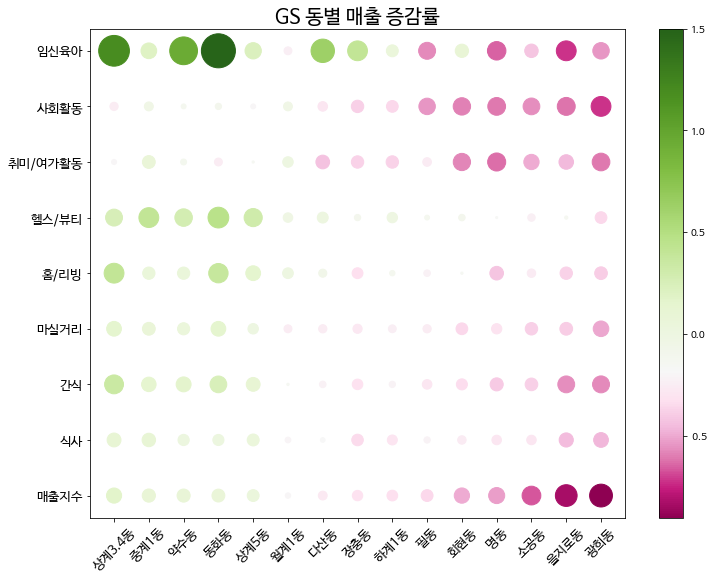

In [ ]:
from sklearn.preprocessing import StandardScaler
from matplotlib import colors


#plt.style.use('bmh')
def heatmap(x,y,val):
    argmax = val.argmax()
    val[argmax] = 1.5
    
    orig_cmap = matplotlib.cm.PiYG
    shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.3, name='sifted')

    plt.figure(figsize=(12,9))
    
    ny = ['매출지수', '식사', '간식', '마실거리', '홈/리빙', '헬스/뷰티', '취미/여가활동', '사회활동', '임신육아']
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in ny]
    
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    scalar = StandardScaler()
    new_val = scalar.fit_transform(val.values.reshape(-1,1))

    size = 100
    plt.scatter(
        x = x.map(x_to_num), # Use mapping for x
        y = y.map(y_to_num), # Use mapping for y
        s = abs(new_val)*250, # Vector of square sizes, proportional to size parameter, 250
        c = val,
        marker='o', # Use square as scatterplot marker
        cmap = shifted_cmap,
    )
    
    # Show column labels on the axes
    plt.title('GS 동별 매출 증감률', fontsize=20)
    plt.xticks([x_to_num[v] for v in x_labels],labels = x_labels, rotation=45, fontsize=13)
    plt.yticks([y_to_num[v] for v in y_labels],labels = y_labels, fontsize=13)
    plt.colorbar()

heatmap(
    x=gs_a_rank_clean['HDONG_NM'],
    y=gs_a_rank_clean['CAT'],
    val = gs_a_rank_clean['VALUE']
)